# Seidel Fitting

<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/seidel_fitting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In this notebook we will fit Seidel coefficients to measured point spread functions. The primary Seidel coefficients are a set of 5 numbers that correspond to common aberrations: Sphere, Coma, Astigmatism, Field Curvature, Distortion.

In [ ]:
# If in Colab, install Chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install git+https://github.com/chromatix-team/chromatix.git

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import Array, PRNGKeyArray

from chromatix.functional import (
    ff_lens,
    objective_point_source,
    phase_change,
)
from chromatix.ops import shot_noise
from chromatix.utils import seidel_aberrations

key = jax.random.PRNGKey(4)

Before we construct our seidel fitter, let's define some simulation parameters based on desired camera specifications.

In [2]:
camera_shape: tuple[int, int] = (256, 256)
camera_pixel_pitch: float = 0.125  # microns
f: float = 100.0  # microns
NA: float = 0.8
n: float = 1.33
wavelength: float = 0.532  # microns
upsample: int = 4
pad: int = 128
crop: int = 450  # for visualization purposes
shape = tuple(e.item() for e in np.array(camera_shape) * upsample + pad)
spacing = upsample * f * wavelength / (n * shape[0] * camera_pixel_pitch)

print(f"Shape of simulation: {shape}")
print(f"Spacing of simulation: {spacing:.2f}")

Shape of simulation: (1152, 1152)
Spacing of simulation: 1.11


## Constructing the forward model 

First we need to model how Seidel coefficients are transformed into PSFs. This is done by plugging in the coefficients into the Seidel polynomial, which yields a 2D phase distribution. This distribution is then used as the phaseof the pupil function, and finally, the Fourier Transform of the pupil function is the PSF.

We implement the model by using an FFLens to Fourier transform the pupil function specified by SeidelAberrations. 

*Note: In general, Seidel aberrations are shift-varying, so we need to specify a location in object space (u,v).*

In [3]:
class SeidelPSF(eqx.Module):
    coefficients: (
        Array  # Only holds the parameters we want to optimize: the Seidel coefficients
    )

    def __call__(
        self, z: Array, u: float, v: float, key: PRNGKeyArray | None = None
    ) -> Array:
        field = objective_point_source(
            shape, spacing, wavelength, z, f, n, NA, power=1e3
        )
        aberrations = seidel_aberrations(
            shape, spacing, wavelength, n, f, NA, self.coefficients, u, v
        )
        field = phase_change(field, aberrations)
        field = ff_lens(field, f, n)
        image = field.intensity
        if key is not None:
            image = shot_noise(key, image)
        return image

Now, using the SeidelPSF forward model, let's generate a "measured" PSF for some "unknown" coefficients that we will ultimately like to learn. For now, we will pick a PSF at the very bottom of the field-of-view with significant Sphere, Coma, and Astigmatism.

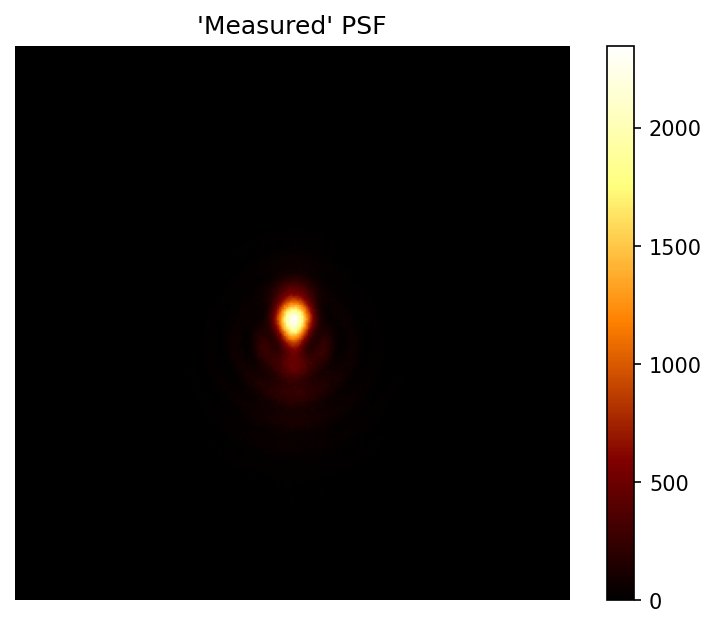

In [4]:
# Initialize model with all 0 coefficients
model = SeidelPSF(jnp.zeros((5,)))

# Specify the "ground truth" coefficients (which will eventually try to estimate)
coefficients_truth = jnp.array([5.0, 5.0, 5.0, 0, 0]) / (2 * jnp.pi / wavelength)
true_model = SeidelPSF(coefficients_truth)

# Get the corresponding "measured" PSF using the true coefficients
psf_truth = true_model(
    z=0.0, u=0.0, v=1.0, key=key
)  # v=1 means this PSF will be near the bottom of the FoV

plt.figure(dpi=150)
plt.imshow(psf_truth[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()

## Learning Seidel Coefficients 

Now that we have our target PSF, we will learn its underlying Seidel coefficients by optimizing through the forward model. First let's define a few functions needed for the training.

In [5]:
# This loss function will be our metric for measuring how close our predicted PSF is to the measured PSF. For now we
# use mean squared error.
def loss_fn(model, data, z, u, v):
    psf_estimate = model(z=z, u=u, v=v)
    loss = jnp.mean(jnp.square(psf_estimate - data))
    return loss, {"loss": loss}


# Creating the optimizer
optimizer = optax.adam(0.001)
opt_state = optimizer.init(model)


# Defining the function that updates the parameters
@jax.jit
def update(model, opt_state, data, z, u, v):
    grads, metrics = jax.grad(loss_fn, has_aux=True)(model, data, z, u, v)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, metrics

Now its time to learn! We using our forward model and the optimization parameters/functions specified above we will
learn the coefficients that correspond to a PSF that best matches our measured PSF. First we display our initial guess.

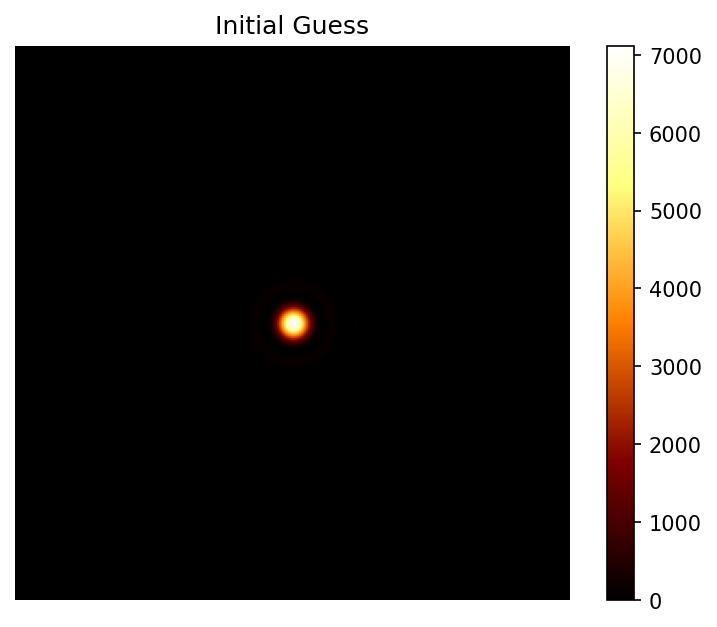

In [6]:
psf_init = model(z=0, u=0, v=1)

plt.figure(dpi=150)
plt.imshow(psf_init[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("Initial Guess")
plt.axis("off")
plt.show()

Below is the optimization loop:

In [7]:
%%time
# Now we optimize
max_iterations = 1000
print_every = 100
history = []
for iteration in range(max_iterations):
    model, metrics = update(model, opt_state, psf_truth, z=0.0, u=0.0, v=1.0)
    # Make sure coefficients don't become negative:
    model = eqx.tree_at(
        lambda t: getattr(t, "coefficients"), model, jnp.abs(model.coefficients)
    )
    history.append(metrics["loss"])
    if iteration % print_every == 0:
        print(iteration, metrics)

0 {'loss': Array(1048.5734, dtype=float32)}
100 {'loss': Array(512.82776, dtype=float32)}
200 {'loss': Array(39.946808, dtype=float32)}
300 {'loss': Array(23.034304, dtype=float32)}
400 {'loss': Array(11.042266, dtype=float32)}
500 {'loss': Array(3.3746903, dtype=float32)}
600 {'loss': Array(0.84318376, dtype=float32)}
700 {'loss': Array(0.84318376, dtype=float32)}
800 {'loss': Array(0.84318376, dtype=float32)}
900 {'loss': Array(0.84318376, dtype=float32)}
CPU times: user 19.3 s, sys: 387 ms, total: 19.7 s
Wall time: 19.8 s


Text(0.5, 0, 'iteration')

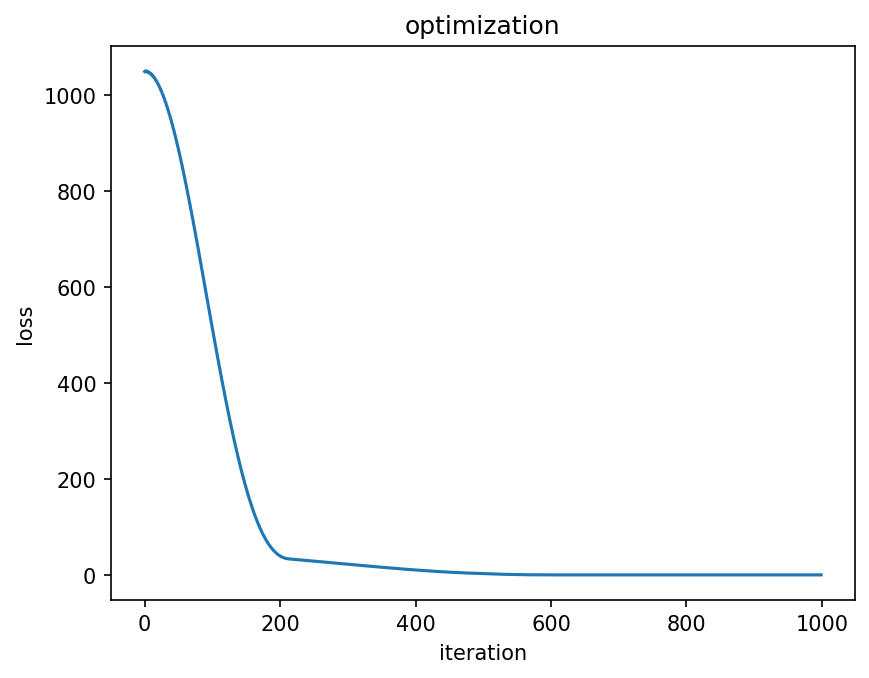

In [8]:
fig = plt.figure(dpi=150)
ax = fig.gca()
ax.plot(history)
ax.set_title("optimization")
ax.set_ylabel("loss")
ax.set_xlabel("iteration")

Let's see how well we did!

In [9]:
# Our final predicted coefficients
coefficients_estimated = model.coefficients
print("Estimated coefficients:", coefficients_estimated)
print("True coefficients:", coefficients_truth)

coefficients_error = jnp.mean(jnp.square(coefficients_estimated - coefficients_truth))
print("Coefficients error:", coefficients_error)

Estimated coefficients: [4.2599541e-01 4.1199559e-01 4.0799564e-01 1.9999836e-03 1.6298145e-09]
True coefficients: [0.42335215 0.42335215 0.42335215 0.         0.        ]
Coefficients error: 7.5156146e-05


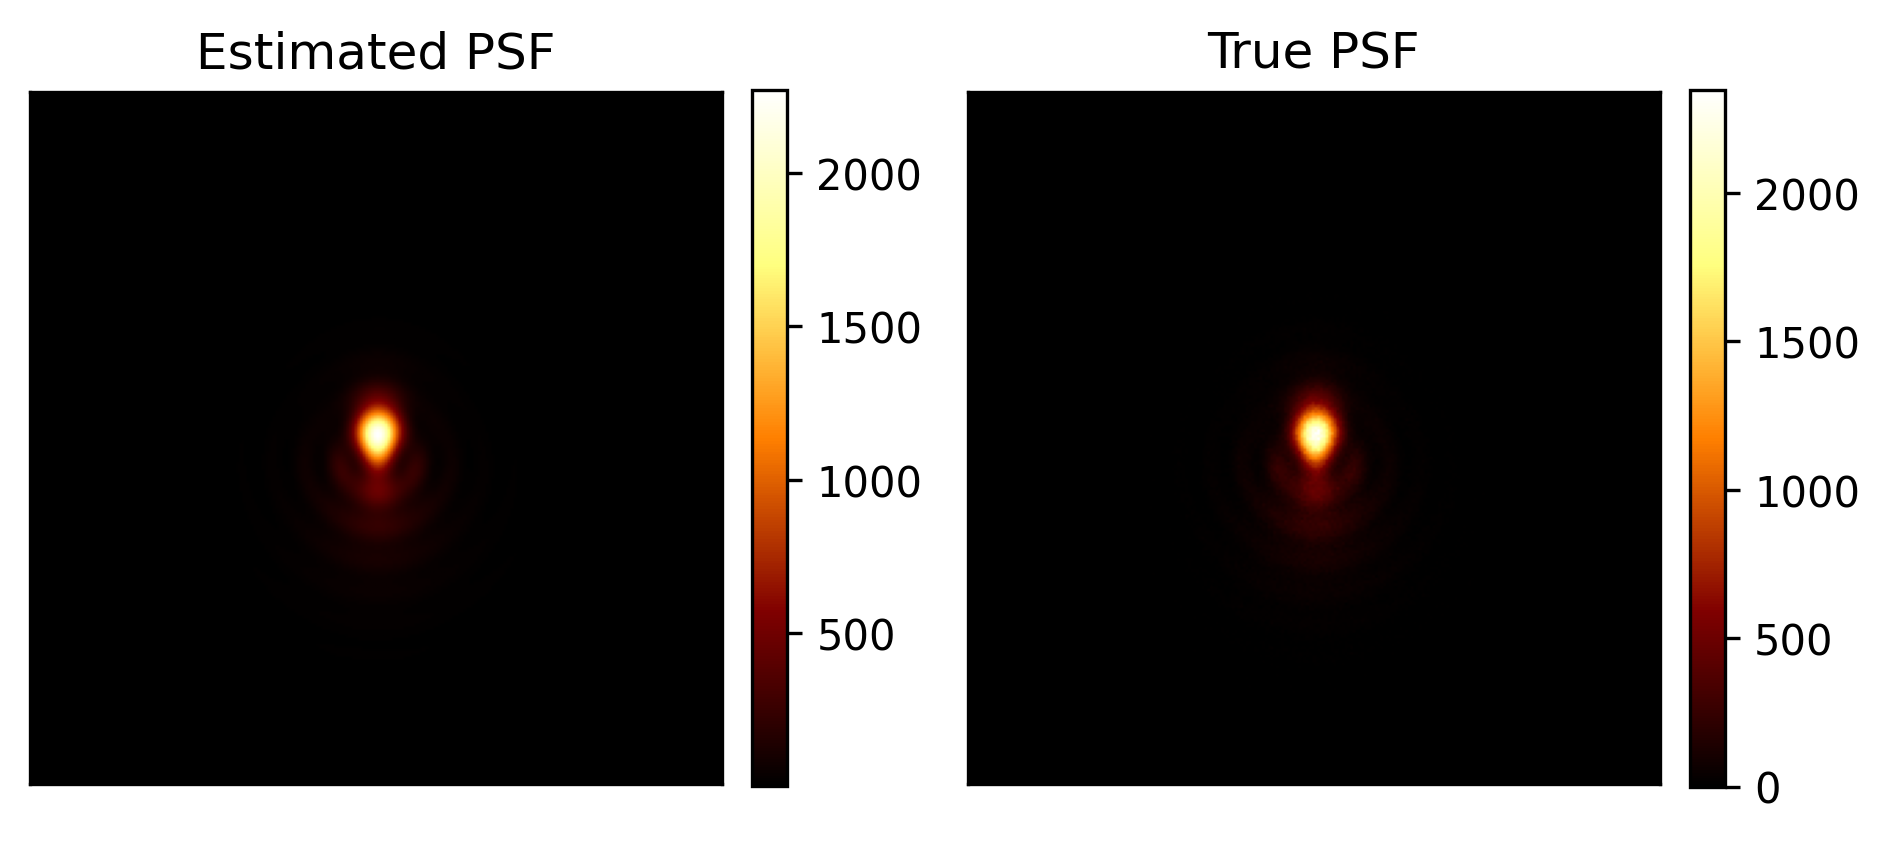

In [10]:
psf_estimated = model(z=0, u=0, v=1)

fig, ax = plt.subplots(1, 2, dpi=300)
m = ax[0].imshow(psf_estimated[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[0].title.set_text("Estimated PSF")
m = ax[1].imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[1].title.set_text("True PSF")
for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()